# Chapter 6: Rerandomization and Regression Adjustment

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
# viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
font = {'family' : 'IBM Plex Sans Condensed',
               'weight' : 'normal',
               'size'   : 10}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (6, 6)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 1

%load_ext watermark
%watermark --iversions


scipy            : 1.10.0
matplotlib       : 3.6.3
numpy            : 1.23.5
seaborn          : 0.12.2
matplotlib_inline: 0.1.6
statsmodels      : 0.13.5
pandas           : 1.5.2



## Regression Adjustment

In [2]:
angrist = pd.read_stata("star.dta")
angrist2 = angrist.query("control == 1 | sfsp == 1")
angrist2['y'] = angrist2.GPA_year1.fillna(angrist2.GPA_year1.mean())


/tmp/ipykernel_305161/576707837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  angrist2['y'] = angrist2.GPA_year1.fillna(angrist2.GPA_year1.mean())


In [3]:
y, z, x = angrist2.y.values, angrist2.sfsp.values, angrist2.loc[:, ['female', 'gpa0']].values


### unadjusted regression

In [4]:
restable = (sm.OLS(y, sm.add_constant(z)).fit(cov_type='HC2').summary().tables[1].as_html())
unadj_res = pd.read_html(restable, header=0, index_col=0)[0].iloc[1, 0:4]


### adjusted (Lin 2013) regression

In [5]:
# standardize x
x = (x - x.mean(axis = 0))/x.std(axis = 0)


In [6]:
restable = (sm.OLS(y,
        sm.add_constant(
            np.c_[z, x, z[:,np.newaxis]*x]
            ))
    .fit(cov_type='HC2').summary().tables[1].as_html()
)
lin_res = pd.read_html(restable, header=0, index_col=0)[0].iloc[1,0:4]


In [7]:
pd.DataFrame(np.c_[unadj_res, lin_res].T,
    columns=['coef', 'se', 't', 'p'],
    index=['unadjusted', 'adjusted']
)


,coef,se,t,p
unadjusted,0.0518,0.078,0.669,0.504
adjusted,0.0682,0.074,0.925,0.355


## Rerandomization simulation

TBD

In [8]:
def Mahalanobis2(z, x):
    x1 = x[z == 1, :]
    x0 = x[z == 0, :]
    n0, n1 = x0.shape[0], x1.shape[0]
    diff = x1.mean(axis = 0) - x0.mean(axis = 0)
    covdiff = (n1 + n0)/ (n1 * n0) * np.cov(x.T)
    M = np.sum(diff * np.linalg.solve(covdiff, diff))
    return M


In [9]:
def rRem(x, n1, n0, a):
    n = n1 + n0
    z = np.random.choice(np.repeat([0, 1], [n0, n1]), size = n, replace = False)
    M = Mahalanobis2(z, x)
    while M > a:
        z = np.random.permutation(z)
        M = Mahalanobis2(z, x)
    return z


In [10]:
x2 = np.c_[x, x**2]
m1lm = sm.WLS(y, sm.add_constant(x2), weights = z).fit()
sigma1 = m1lm.scale**(0.5)

m0lm = sm.WLS(y, sm.add_constant(x2), weights = 1-z).fit()
sigma0 = m0lm.scale**(0.5)


In [11]:
def design_adjustment_fig(rescale):
    a = 0.05
    MC = 1000
    n, n1, n0 = len(z), sum(z), sum(1-z)

    y1impute = m1lm.predict(sm.add_constant(x2)) + np.random.normal(0, sigma1 * rescale, n)
    y0impute = m0lm.predict(sm.add_constant(x2)) + np.random.normal(0, sigma1 * rescale, n)
    tauimpute = np.mean(y1impute - y0impute)

    TauHatCRE = np.zeros(MC)
    TauHatRegCRE = np.zeros(MC)
    TauHatReM = np.zeros(MC)
    TauHatRegReM = np.zeros(MC)

    for i in range(MC):
        zCRE = np.random.permutation(z)
        yCRE = zCRE * y1impute + (1-zCRE) * y0impute
        TauHatCRE[i] = np.mean(yCRE[zCRE == 1]) - np.mean(yCRE[zCRE == 0])
        TauHatRegCRE[i] = (sm.OLS(yCRE,
            sm.add_constant(np.c_[zCRE, x, zCRE[:, np.newaxis]*x]))
        .fit().params[1])

        ZReM = rRem(x, int(n1), int(n0), a)
        yRem = ZReM * y1impute + (1-ZReM) * y0impute
        TauHatReM[i] = np.mean(yRem[ZReM == 1]) - np.mean(yRem[ZReM == 0]) - tauimpute
        TauHatRegReM[i] = (sm.OLS(yRem,
            sm.add_constant(np.c_[ZReM, x, ZReM[:, np.newaxis]*x])).fit().params[1])

    data = [TauHatCRE - tauimpute, TauHatRegCRE - tauimpute,
            TauHatReM - tauimpute, TauHatRegReM - tauimpute]
    fig, ax = plt.subplots()
    ax.violinplot(data, showmeans=True, showmedians=True)
    ax.set_title('TauHats for rescale = {}'.format(rescale))
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(['TauHatCRE', 'TauHatRegCRE', 'TauHatReM', 'TauHatRegReM'])
    plt.show()


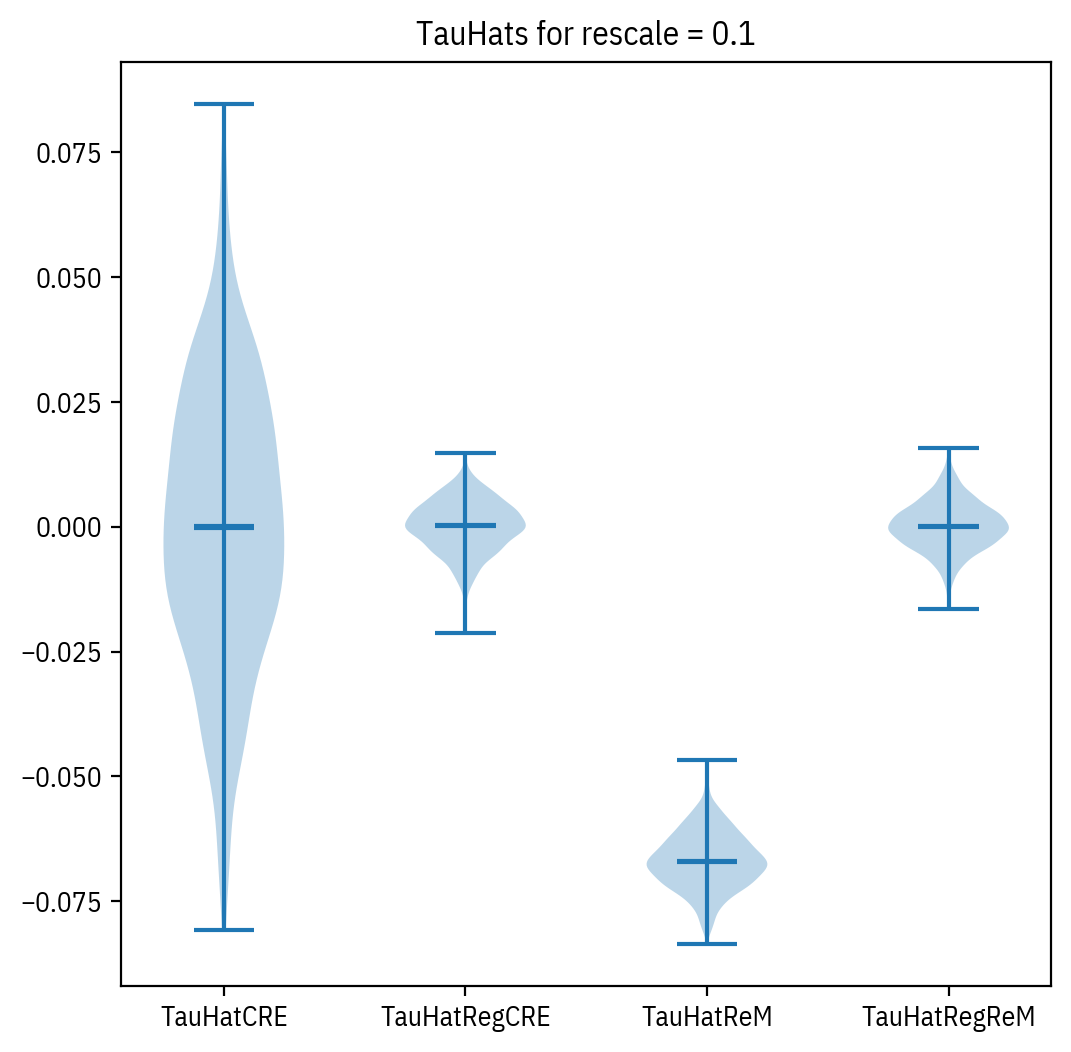

In [12]:
design_adjustment_fig(0.1)


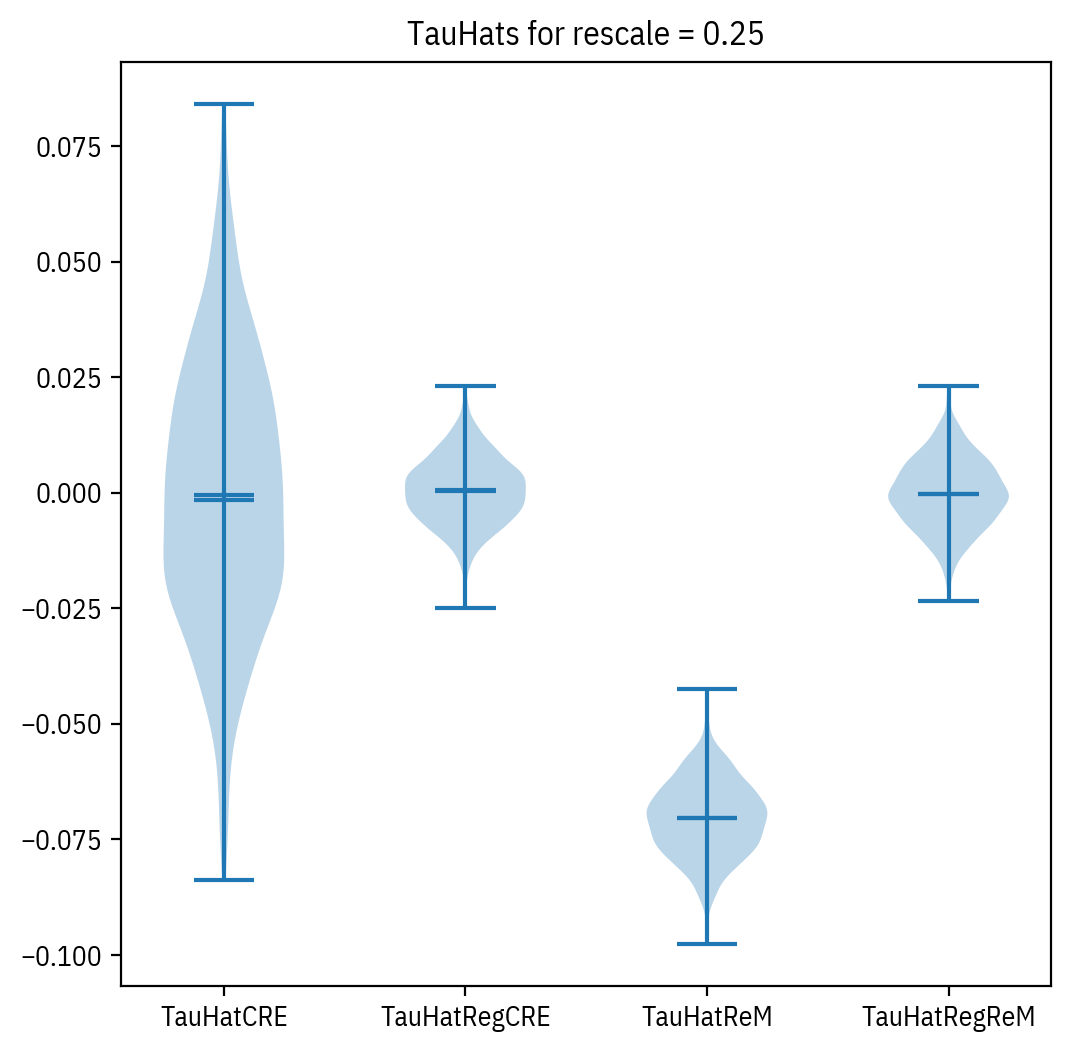

In [13]:
design_adjustment_fig(0.25)
